# Predicting customers who will "charge-off"

#Define charge-off
Steps:
1. Data Cleaning
2. Feature selection and transformation
3. Build the models
4. Test the models

Before starting: Install the imblearn python package on your computer! 
    
    Run the following in terminal: pip install -U imbalanced-learn

Let's load the libraries, connect to the database, parse dates and load all data in-memory. Make sure the three files database.sqlite, LCDataDictionary.xlsx, and loan.csv are all in the same folder as this notebook.

In [1]:
import sqlite3 #this library manages sql databases
import pandas as pd  #this library enables data manipulation and analysis methods to be used in Python
import numpy as np #this library focuses on scientific computing and using arrays and matrices
%matplotlib inline 

import matplotlib.pyplot as plt #this imports the matplotlib library, along with the interactive plotting pylab modul
from datetime import datetime

In [3]:
test_data = pd.read_csv("test_data_cleaned.gz", compression='gzip', header=0, sep=',', quotechar='"')

In [4]:
loan_data = pd.read_csv('loan_data_cleaned.gz', compression='gzip', header=0, sep=',', quotechar='"')

This illusrates my concation process, DO NOT RUN AS PART OF CODE

In [3]:
df_2014 = pd.read_csv('LoanStats3c.csv', header = 1)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_2014.shape 

(235631, 145)

In [5]:
df_2014.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,21425.0,21425.0,21425.0,60 months,15.59%,516.36,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,12800.0,12800.0,12800.0,60 months,17.14%,319.08,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,9600.0,9600.0,9600.0,36 months,13.66%,326.53,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_2014 = pd.read_csv('LoanStats3c.csv', header = 1)
d = [2014,12]
df_2014 = df_2014.assign(data_year = d[0])
df_2014 = df_2014.assign(data_month = d[1])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_2014.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,data_year,data_month
0,NaN,NaN,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014,12
1,NaN,NaN,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014,12
2,NaN,NaN,21425.0,21425.0,21425.0,60 months,15.59%,516.36,D,D1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014,12
3,NaN,NaN,12800.0,12800.0,12800.0,60 months,17.14%,319.08,D,D4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014,12
4,NaN,NaN,9600.0,9600.0,9600.0,36 months,13.66%,326.53,C,C3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014,12


First I will concate the accepted and rejected loans data into one csv and save 2018 data for tests

In [3]:
df_2007_2011 = pd.read_csv('LoanStats3a.csv' , header = 1) # importing lending club loan data
df_2012_2013 = pd.read_csv('LoanStats3b.csv' , header = 1)
df_2014 = pd.read_csv('LoanStats3c.csv', header = 1)
d = [2014 , 12]
df_2014 = df_2014.assign(data_year = d[0]) 
df_2014 = df_2014.assign(data_month = d[1])
# adding data_date (yr and month) to create loan age and avg. ammortization per month factor
df_2015 = pd.read_csv('LoanStats3d.csv', header = 1)
d = [2015 , 12]
df_2015 = df_2015.assign(data_year = d[0]) 
df_2015 = df_2015.assign(data_month = d[1])
df_2016a = pd.read_csv('LoanStats_2016Q1.csv', header = 1)
d = [2016 , 3]
df_2016a = df_2016a.assign(data_year = d[0]) 
df_2016a = df_2016a.assign(data_month = d[1])
df_2016b = pd.read_csv('LoanStats_2016Q2.csv', header = 1)
d = [2016 , 6]
df_2016b = df_2016b.assign(data_year = d[0]) 
df_2016b = df_2016b.assign(data_month = d[1])
df_2016c = pd.read_csv('LoanStats_2016Q3.csv', header = 1)
d = [2016 , 9]
df_2016c = df_2016c.assign(data_year = d[0]) 
df_2016c = df_2016c.assign(data_month = d[1])
df_2016d = pd.read_csv('LoanStats_2016Q4.csv', header = 1)
d = [2016 , 12]
df_2016d = df_2016d.assign(data_year = d[0]) 
df_2016d = df_2016d.assign(data_month = d[1])
df_2017a = pd.read_csv('LoanStats_2017Q1.csv', header = 1)
d = [2017 , 3]
df_2017a = df_2017a.assign(data_year = d[0]) 
df_2017a = df_2017a.assign(data_month = d[1])
df_2017b = pd.read_csv('LoanStats_2017Q2.csv', header = 1)
d = [2017 , 6]
df_2017b = df_2017b.assign(data_year = d[0]) 
df_2017b = df_2017b.assign(data_month = d[1])
df_2017c = pd.read_csv('LoanStats_2017Q3.csv', header = 1)
d = [2017 , 9]
df_2017c = df_2017c.assign(data_year = d[0]) 
df_2017c = df_2017c.assign(data_month = d[1])
df_2017d = pd.read_csv('LoanStats_2017Q4.csv', header = 1)
d = [2017 , 12]
df_2017d = df_2017d.assign(data_year = d[0]) 
df_2017d = df_2017d.assign(data_month = d[1])

frames = [df_2007_2011,df_2012_2013,df_2014,df_2015,df_2016a,df_2016b,df_2016c,df_2016d,df_2017a,df_2017b,df_2017c,df_2017d]
accept = pd.concat(frames)
accept = accept.assign(accepted = True)


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,47,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, 

In [4]:
accept.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,accepted
0,0.0,NaN,AZ,NaN,24000.0,NaN,Individual,NaN,NaN,NaN,...,5833.84,863.16,0.00,5000.00,NaN,NaN,Verified,NaN,860xx,True
1,0.0,NaN,GA,NaN,30000.0,NaN,Individual,NaN,NaN,NaN,...,1014.53,435.17,0.00,456.46,NaN,NaN,Source Verified,NaN,309xx,True
2,0.0,NaN,IL,NaN,12252.0,NaN,Individual,NaN,NaN,NaN,...,3005.67,605.67,0.00,2400.00,NaN,NaN,Not Verified,NaN,606xx,True
3,0.0,NaN,CA,NaN,49200.0,NaN,Individual,NaN,NaN,NaN,...,12231.89,2214.92,16.97,10000.00,NaN,NaN,Source Verified,NaN,917xx,True
4,0.0,NaN,OR,NaN,80000.0,NaN,Individual,NaN,NaN,NaN,...,4066.91,1066.91,0.00,3000.00,NaN,NaN,Source Verified,NaN,972xx,True


In [5]:
accept.tail()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,accepted
118645,0.0,3.0,IL,93.0,64000.0,NaN,Individual,31623.0,136.0,93.2,...,3314.34,885.28,0.0,2429.06,10000.0,NaN,Source Verified,NaN,603xx,True
118646,0.0,8.0,NY,51.0,60000.0,NaN,Individual,1982.0,9816.0,49.7,...,4499.68,2806.85,0.0,1692.83,50700.0,NaN,Not Verified,NaN,112xx,True
118647,0.0,5.0,AK,55.0,60000.0,NaN,Individual,8155.0,18789.0,14.6,...,3241.15,2013.72,0.0,1227.43,37000.0,NaN,Not Verified,NaN,996xx,True
118648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
118649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [6]:
accept.to_csv("Accepted.csv") 

In [9]:
df_2018Q1 = pd.read_csv('LoanStats_2018Q1.csv', header = 1)
d = [2018 , 3]
df_2018Q1 = df_2018Q1.assign(data_year = d[0]) 
df_2018Q1 = df_2018Q1.assign(data_month = d[1])
df_2018Q2 = pd.read_csv('LoanStats_2018Q2.csv', header = 1)
d = [2018 , 6]
df_2018Q2 = df_2018Q2.assign(data_year = d[0]) 
df_2018Q2 = df_2018Q2.assign(data_month = d[1])
frames =[df_2018Q1,df_2018Q2] 
accept_test = pd.concat(frames)
accept_test = accept_test.assign(accepted = True)
accept.to_csv("Accepted_test.csv")


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df_2007_2012 = pd.read_csv('RejectStatsA.csv', header = 1)
df_2013_2014 = pd.read_csv('RejectStatsB.csv', header = 1)
df_2015 = pd.read_csv('RejectStatsD.csv', header = 1)
d = [2015 , 12]
df_2015 = df_2015.assign(data_year = d[0]) 
df_2015 = df_2015.assign(data_month = d[1])
df_2016a = pd.read_csv('RejectStats_2016Q1.csv', header = 1)
d = [2016 , 3]
df_2016a = df_2016a.assign(data_year = d[0]) 
df_2016a = df_2016a.assign(data_month = d[1])
df_2016b = pd.read_csv('RejectStats_2016Q2.csv', header = 1)
d = [2016 , 6]
df_2016b = df_2016b.assign(data_year = d[0]) 
df_2016b = df_2016b.assign(data_month = d[1])
df_2016c = pd.read_csv('RejectStats_2016Q3.csv', header = 1)
d = [2016 , 9]
df_2016c = df_2016c.assign(data_year = d[0]) 
df_2016c = df_2016c.assign(data_month = d[1])
df_2016d = pd.read_csv('RejectStats_2016Q4.csv', header = 1)
d = [2016 , 12]
df_2016d = df_2016d.assign(data_year = d[0]) 
df_2016d = df_2016d.assign(data_month = d[1])
df_2017a = pd.read_csv('RejectStats_2017Q1.csv', header = 1)
d = [2017 , 3]
df_2017a = df_2017a.assign(data_year = d[0]) 
df_2017a = df_2017a.assign(data_month = d[1])
df_2017b = pd.read_csv('RejectStats_2017Q2.csv', header = 1)
d = [2017 , 6]
df_2017b = df_2017b.assign(data_year = d[0]) 
df_2017b = df_2017b.assign(data_month = d[1])
dfR_2017c = pd.read_csv('RejectStats_2017Q3.csv', header = 1)
d = [2017 , 9]
df_2017c = df_2017c.assign(data_year = d[0]) 
df_2017c = df_2017c.assign(data_month = d[1])
df_2017d = pd.read_csv('RejectStats_2017Q4.csv', header = 1)
d = [2017 , 12]
df_2017d = df_2017d.assign(data_year = d[0]) 
df_2017d = df_2017d.assign(data_month = d[1])

frames = [df_2007_2012,df_2013_2014,df_2015,df_2016a,df_2016b,df_2016c,df_2016d,df_2017a,df_2017b,df_2017c,df_2017d]
reject = pd.concat(frames)
reject = reject.assign(accepted = False)
reject.to_csv("Rejected.csv") 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
reject.head()

,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Loan Title,Policy Code,Risk_Score,State,Zip Code,acc_now_delinq,...,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,accepted
0,1000.0,2007-05-26,10%,4 years,Wedding Covered but No Honeymoon,0.0,693.0,NM,481xx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1000.0,2007-05-26,10%,< 1 year,Consolidating Debt,0.0,703.0,MA,010xx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,11000.0,2007-05-27,10%,1 year,Want to consolidate my debt,0.0,715.0,MD,212xx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,6000.0,2007-05-27,38.64%,< 1 year,waksman,0.0,698.0,MA,017xx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,1500.0,2007-05-27,9.43%,< 1 year,mdrigo,0.0,509.0,MD,209xx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [12]:
reject.shape

(16267641, 157)

In [20]:
df_2018Q1 = pd.read_csv('RejectStats_2018Q1.csv', header = 1)
d = [2018 , 3]
df_2018Q1 = df_2018Q1.assign(data_year = d[0]) 
df_2018Q1 = df_2018Q1.assign(data_month = d[1])
df_2018Q2 = pd.read_csv('RejectStats_2018Q2.csv', header = 1)
d = [2018 , 6]
df_201Q2 = df_2018Q2.assign(data_year = d[0]) 
df_2018Q2 = df_201Q2.assign(data_month = d[1])
frames =[df_2018Q1,df_2018Q2] 
reject_test = pd.concat(frames)
result = reject_test.assign(accepted = False)
result.to_csv("Rejected_test.csv")


In [32]:
accept = pd.read_csv('Accepted.csv') # make sure created csv works properly

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14,16,20,32,36,38,39,40,41,43,72,97,111,120,122,145) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
accept.head()

,Unnamed: 0,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,...,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,accepted
0,0,0.0,NaN,AZ,NaN,24000.0,NaN,Individual,NaN,NaN,...,5833.84,863.16,0.00,5000.00,NaN,NaN,Verified,NaN,860xx,1
1,1,0.0,NaN,GA,NaN,30000.0,NaN,Individual,NaN,NaN,...,1014.53,435.17,0.00,456.46,NaN,NaN,Source Verified,NaN,309xx,1
2,2,0.0,NaN,IL,NaN,12252.0,NaN,Individual,NaN,NaN,...,3005.67,605.67,0.00,2400.00,NaN,NaN,Not Verified,NaN,606xx,1
3,3,0.0,NaN,CA,NaN,49200.0,NaN,Individual,NaN,NaN,...,12231.89,2214.92,16.97,10000.00,NaN,NaN,Source Verified,NaN,917xx,1
4,4,0.0,NaN,OR,NaN,80000.0,NaN,Individual,NaN,NaN,...,4066.91,1066.91,0.00,3000.00,NaN,NaN,Source Verified,NaN,972xx,1


In [34]:
reject = pd.read_csv('Rejected.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
reject.head()

,Unnamed: 0,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Loan Title,Policy Code,Risk_Score,State,Zip Code,data_date,accepted
0,0,1000.0,2007-05-26,10%,4 years,Wedding Covered but No Honeymoon,0.0,693.0,NM,481xx,NaN,0
1,1,1000.0,2007-05-26,10%,< 1 year,Consolidating Debt,0.0,703.0,MA,010xx,NaN,0
2,2,11000.0,2007-05-27,10%,1 year,Want to consolidate my debt,0.0,715.0,MD,212xx,NaN,0
3,3,6000.0,2007-05-27,38.64%,< 1 year,waksman,0.0,698.0,MA,017xx,NaN,0
4,4,1500.0,2007-05-27,9.43%,< 1 year,mdrigo,0.0,509.0,MD,209xx,NaN,0


In [14]:
frames = [accept,reject] 
loan_data = pd.concat(frames)
loan_data.to_csv("2008-2017 Loan Data.csv")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [37]:
accept_test = pd.read_csv('Accepted_test.csv')
reject_test = pd.read_csv('Rejected_test.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14,16,20,32,36,38,39,40,41,43,72,97,111,120,122,145) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
frames =[accept_test,reject_test] 
test_data = pd.concat(frames)
test_data.to_csv("Test Data.csv")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


# I can now use my new data set which includes the new "accepted" variable

In [16]:
loan_data.shape

(18033092, 157)

In [17]:
loan_data.head()

,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Loan Title,Policy Code,Risk_Score,State,Zip Code,acc_now_delinq,...,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,5863.155187,5833.84,863.16,0.00,5000.00,NaN,NaN,Verified,NaN,860xx
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,1014.530000,1014.53,435.17,0.00,456.46,NaN,NaN,Source Verified,NaN,309xx
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,3005.666844,3005.67,605.67,0.00,2400.00,NaN,NaN,Not Verified,NaN,606xx
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,12231.890000,12231.89,2214.92,16.97,10000.00,NaN,NaN,Source Verified,NaN,917xx
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,4066.908161,4066.91,1066.91,0.00,3000.00,NaN,NaN,Source Verified,NaN,972xx


In [22]:
list(loan_data.columns.values)

['Amount Requested',
 'Application Date',
 'Debt-To-Income Ratio',
 'Employment Length',
 'Loan Title',
 'Policy Code',
 'Risk_Score',
 'State',
 'Zip Code',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'accepted',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'data_month',
 'data_year',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'disbursement_method',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'home_o

In [43]:
test_data.shape

(6082566, 158)

In [44]:
test_data.head()

,Unnamed: 0,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Loan Title,Policy Code,Risk_Score,State,Unnamed: 0.1,...,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,5863.155187,5833.84,863.16,0.00,5000.00,NaN,NaN,Verified,NaN,860xx
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,1014.530000,1014.53,435.17,0.00,456.46,NaN,NaN,Source Verified,NaN,309xx
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,3005.666844,3005.67,605.67,0.00,2400.00,NaN,NaN,Not Verified,NaN,606xx
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,...,12231.890000,12231.89,2214.92,16.97,10000.00,NaN,NaN,Source Verified,NaN,917xx
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,...,4066.908161,4066.91,1066.91,0.00,3000.00,NaN,NaN,Source Verified,NaN,972xx


## Data Cleaning


### Check which features have good coverage, e.g. more/less than N% missing values

In [15]:
del loan_data['url']
del loan_data['Policy Code']
del test_data['url']
del test_data['Policy Code']
del test_data['Unnamed: 0']
del loan_data['Unnamed: 0']

In [44]:
list(test_data.columns.values)

['Amount Requested',
 'Application Date',
 'Debt-To-Income Ratio',
 'Employment Length',
 'Loan Title',
 'Risk_Score',
 'State',
 'Zip Code',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'accepted',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'data_month',
 'data_year',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'disbursement_method',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'home_ownership',
 'id'

In [45]:
list(loan_data.columns.values)

['Amount Requested',
 'Application Date',
 'Debt-To-Income Ratio',
 'Employment Length',
 'Loan Title',
 'Risk_Score',
 'State',
 'Zip Code',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'accepted',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'data_month',
 'data_year',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'disbursement_method',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'home_ownership',
 'id'

In [16]:
loan_data.dropna()
test_data.dropna()
# get rid of empty column

,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Loan Title,Risk_Score,State,Zip Code,acc_now_delinq,acc_open_past_24mths,...,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,verification_status_joint,zip_code


# Determine signigicance of nearly empty columns

In [ ]:
check_null = loan_data.isnull().sum(axis=0).sort_values(ascending=False)/float(len(loan_data))#.isnull() is a pandas feature that checks for missing values
#.sum() is a feature that will sum the previous feature of how many null values, with axis = 0 representing a vertical concatenation, which checks down the column of each dataframe. If axis = 1, this would be a horizontal concatenation checking each row instead of columns
#sort_values will then sort the results, with ascending = False meaning that results will be sorted is a descending order. This is all divided by the length of the dataframe, which has been converted to a float value
 #outputs the feature and fraction of missing values

In [ ]:
d = dict(check_null[check_null > .7])
null_data = list(d.keys())

In [ ]:
print(null_data) #could be important in the future

### Checking Features With Little Variation or No Use

A lot of these columns have NaN values, or have little variation. Neither of these will be super useful to us. Let us first look at the columns with little variation, NaN values, and then drop columns we do not need.

1) index
2) policy_code
3) pymnt_plan
4) url
5) id
6) member_id
8) acc_now_delinq
9) emp_title
10) zip_code
11) title

Index is already built into the dataframe, so let us drop it.

#### Exploring Columns with Little Variation

We will now use .groupby to group the dataframe by the specified columns above and sort each column by its values to showcase how much variation these columns have.

In [7]:
#get grouped data
loan_data.groupby('policy_code').size().sort_values()
#.groupby is a pandas feature that will group the dataframe amongst groups designated by mappers or column names
#in this case we want the policy_code data so we will group by inputting the column policy_code to get that data
#.size() will compute the group size
#.sort_values() will then sort the values
#since all values are the same, we get the following: 1.0 value for POlicy_code amongst all 887382 rows

policy_code
1.0    887382
dtype: int64

In [17]:
del loan_data['policy_code']
del test_data['policy_code']

In [8]:
#check for variation
np.var(df.filter(regex='policy_code'))
#np is numpy
#.var is a numpy feature that will return the variance for the specified elements
#df.filter serves to filter the data we want the variance on
#regex stands for regular expression, which we are inputting as policy_code to specify this is the data we want variance on
#note that variance only works when checking numbers (int/float), not strings

policy_code    0.0
dtype: float64

An output of 0 means there is no variance, which makes sense as policy_code is always = 1.0.

In [9]:
loan_data.groupby('pymnt_plan').size().sort_values()

pymnt_plan
y        10
n    887372
dtype: int64

In [10]:
#Now we are going to try a loop to see if we can catch the number of unique values in this column
#we do a loop instead of the above variance method as variance only works on numbers, and this column has string values of "yes" or "no"
unique = [] #set an empty list
for x in loan_data.groupby('pymnt_plan').size().sort_values(): #create a for loop, saying that for each value in the payment plan column
    if x not in unique: #for each of those values, if they are not in the unique list
        unique.append(x) #append/add the value to the list
print(len(unique)) #after the loop ends, print out the length of the unique list, which effectively gives us the number of unique values

2


In [18]:
del loan_data['pymnt_plan']
del test_data['pymnt_plan']

Only 2 different values. For pymnt_plan, only 10 rows take the value "yes", which means there is little useful variation. URL, ID doesn't seem to have any useful information.

In [11]:
df.groupby('application_type').size().sort_values()

application_type
JOINT            511
INDIVIDUAL    886871
dtype: int64

In [13]:
np.var(df.filter(regex='acc_now_delinq'))

acc_now_delinq    0.006026
dtype: float64

The variance is quite low, meaning that the values are close to each other. Also notice the majority of values are concentrated at 0.0

In [14]:
df.groupby('emp_title').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

emp_title
 \tAdv Mtr Proj Fld Rep                         1
Risk Systems Analyst                            1
Risk advisory supervisor                        1
Risk analysis                                   1
Risk and Control Analyst II                     1
Risk and Safety Management                      1
Risk consultant                                 1
Risk control                                    1
Risk coordinator                                1
Risk director                                   1
Risk enterprise management                      1
Risk management advisor                         1
Risk management assistant                       1
Risk officer                                    1
Risk System Analyst                             1
Risk services manager                           1
Risk/Control Officer                            1
RiskMetrics Group                               1
Risks and Controls Sr Analyst                   1
Risnychok & Associates, Inc.            

In [ ]:
unique = []
for x in df.groupby('emp_title').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique))

So there are a lot of different professions here. Perhaps we can use that later.

In [16]:
df.groupby('zip_code').size().sort_values() # for now, we don't use that variable, but perhaps we can use it in the future?

zip_code
649xx       1
643xx       1
862xx       1
621xx       1
817xx       1
849xx       1
819xx       1
507xx       1
509xx       1
682xx       1
511xx       1
513xx       1
514xx       1
516xx       1
520xx       1
569xx       1
568xx       1
429xx       1
524xx       1
889xx       1
694xx       1
892xx       1
399xx       1
375xx       1
901xx       1
909xx       1
742xx       1
205xx       1
938xx       1
888xx       1
         ... 
920xx    4303
956xx    4329
600xx    4518
604xx    4527
021xx    4532
080xx    4539
601xx    4603
481xx    4645
334xx    4744
113xx    4813
925xx    4907
913xx    5161
926xx    5415
852xx    5442
921xx    5661
104xx    6008
117xx    6129
330xx    6283
917xx    6357
891xx    6441
770xx    6938
900xx    7287
331xx    7416
070xx    7431
100xx    7609
300xx    8126
606xx    8641
112xx    9272
750xx    9417
945xx    9770
Length: 935, dtype: int64

In [17]:
unique = []
for x in df.groupby('zip_code').size().sort_values():
    if x not in unique:
        unique.append(x) 

695


In [77]:
loan_data.groupby('title').size().sort_values()

title
îîMY FIRST CAR îî                         1
PAY_CREDIT_CARDS_OFF                              1
PAyoff                                            1
PB&J Wedding                                      1
PCS Simplification                                1
PEACE  OF  MIND                                   1
lower rate  to save money                         1
lower payments/debt                               1
lower payments, home improvements, babies         1
PEACE of mind                                     1
PEICE OF MIND                                     1
PAYS OFF ALL DEBT-CLOSE ALL CC START NEW          1
PEPE LOAN                                         1
PEROSNAL                                          1
lower payments                                    1
PERSONAL BILL CONSOLIDATE                         1
PERSONAL BUSINESS                                 1
PERSONAL CONSOLIDATE                              1
PERSONAL CONSOLIDATION                            1
PERSON

In [26]:
titles = list(loan_data.title)
print((titles[100]))
print((titles[100][1]).isupper()) # is second letter uppercase?
second_letter = []
type(titles[100][2])

Wells/Chase ReFi
False


str

In [50]:
import enchant #spell checking software
d = enchant.Dict("en_US")
print(titles[100])
word1 = titles[100].split(' ', 1)[0]
print (word1)

Wells/Chase ReFi
Wells/Chase


In [66]:
titles = list(loan_data.title.fillna("AA"))
title_accuracy = []
import enchant #spell checking software
d = enchant.Dict("en_US")

In [67]:
for i in range (0,len(titles)):
    if (titles[i][1].isupper()) == True: #check if only first letter is capitilized 
        title_accuracy.append(False) 
    elif (d.check(titles[i]) == False): #check if word is misspelled  
        title_accuracy.append(False)
    else:  
        title_accuracy.append(True) 

In [70]:
loan_data = loan_data.assign(title_accurate = title_accuracy) #this is my new predictor

In [71]:
unique = []
for x in loan_data.groupby('title_accurate').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique)) #Make sure only True & False

2


In [72]:
del loan_data['title'] 

In [75]:
titles = list(test_data.title.fillna("AA"))
title_accuracy = []

In [76]:
for i in range (0,len(titles)):
    if (titles[i][1].isupper()) == True: #check if only first letter is capitilized 
        title_accuracy.append(False) 
    elif (d.check(titles[i]) == False): #check if word is misspelled  
        title_accuracy.append(False)
    else:  
        title_accuracy.append(True) 

In [77]:
test_data = test_data.assign(title_accurate = title_accuracy) #this is my new predictor

In [176]:
unique = []
for x in test_data.groupby('accepted').size().sort_values():
    if x not in unique:
        unique.append(x)
print(len(unique)) #Make sure only True & False

1


In [79]:
del test_data['title'] 

## Feature transformations

We need to transform a few metrics which sound very important, but are formatted as strings. These transformations are performed with the data modelling in mind. Ultimatelly we want to produce a dataset almost ready to be fed to the model. Here is a summary of the operations performed:

1) Strip months from term and make it an integer
2) The Interest rate is a string. Remove % and make it a float
3) Extract numbers from emp_length and fill missing values with the median. If emp_length == 10+ years then leave it as 10
4) Transform datetimes to a Period (class in Pandas)

In [19]:
#1. Strip `months` from `term` e.g. "36 month" to "36"
loan_data['term'] = loan_data['term'].str.split(' ').str[1]
test_data['term'] = test_data['term'].str.split(' ').str[1]
#breaking term values by space, turning [36 months] into [36, months]
#Can anyone figure out why the index is 1 instead of 0? 

In [5]:
loan_data['emp_length'] = loan_data['emp_length'].str.extract('(\d+)').astype(float)
test_data['emp_length'] = test_data['emp_length'].str.extract('(\d+)').astype(float)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [20]:
#interest rate is a string. Remove % and make it a float. 
loan_data['int_rate'] = loan_data['int_rate'].str.split('%').str[0]
#break int_rate terms by %, turning [10.65%] into [10.65]
loan_data['int_rate'] = loan_data.int_rate.astype(float)/100.
#making it so that int_rate is now assigned type float
#divide by 100 to convert to decimal and ensure proper value since % was removed
test_data['int_rate'] = test_data['int_rate'].str.split('%').str[0]
test_data['int_rate'] = test_data.int_rate.astype(float)/100.

In [24]:
# create new avg. payment per month column
    #total_bal_il Total current balance of all installment accounts
    #tot_coll_amt Total collection amounts ever owed
    #mo_sin_old_il_acct Months since oldest bank installment account opened  
loan_data['tot_coll_amt']= loan_data['tot_coll_amt'].fillna(0) 
loan_data['total_bal_il']= loan_data['total_bal_il'].fillna(0) 
loan_data['mo_sin_old_il_acct'] = loan_data['mo_sin_old_il_acct'].fillna(0)
loan_data['avg_pymnt_monthly'] = ((loan_data['tot_coll_amt'].astype(float) - loan_data['total_bal_il'].astype(float)) / loan_data['mo_sin_old_il_acct'].astype(float))



In [21]:
col_dates = loan_data.dtypes[loan_data.dtypes == 'datetime64[ns]'].index
#selecting all values in dataframe whose datatype is equal to datetimes, assigning to col_dates
for d in col_dates:
    loan_data[d] = loan_data[d].dt.to_period('M')
    
col_dates = test_data.dtypes[loan_data.dtypes == 'datetime64[ns]'].index
for d in col_dates:
    test_data[d] = test_data[d].dt.to_period('M')
#creating for loop where for all dates in col_dates, the datatype will be converted to period
#Periods are a class in Python that represent periods of time, and are much easier to manipulate than the current format
#'M' input for to_period stands for months, since that is the time period we are dealing with

In [ ]:
loan_data.dtypes #check types

In [ ]:
loan_data.head() #success

In [73]:
#I will save my changes to updated csv files
loan_data.to_csv("Loan Data.csv")

In [80]:
test_data.to_csv("Test Data.csv")

Now I will merge employment data with the BLS data (additional future improvement)

# Data Modelling

Let's build a model which predicts the status charged_off or not accepted. (Which question does that answer? Are you perhaps also interested in answering different questions?) Let's first check which fraction of the observations is charged off.

In [134]:
print(status.isnull().sum(axis=0)/float(len(status)))

0.0


In [153]:
accepted = list(loan_data['accepted'])

pandas.core.series.Series

In [139]:
len(status)

18033092

In [25]:
accepted = loan_data['accepted']
status = loan_data['loan_status'].fillna("")
for i in range (0,len(status)):
    if (status[i] == ("")):
        if (accepted[i] == False):
            status[i] = 'rejected'
        else:
            status[i] = 'unknown'
loan_data['loan_status'] = status

In [17]:
loan_data['accepted'] = loan_data['accepted'].astype(bool)

In [26]:
test_data['accepted'] = test_data['accepted'].fillna(False)

In [27]:
test_data['accepted'] = test_data['accepted'].astype(bool)

In [156]:
loan_status_grouped = loan_data.groupby('loan_status').size().sort_values(ascending=False)/len(loan_data) * 100
#checking each loan status by pulling the column of statuses and sorting from high to low commonality
#divide by length of data frame in end to figure out percentage of total dataframe that is status
#multiply by 100 since percentages (since there is no % sign)
loan_status_grouped
#show status breakdown

loan_status
rejected                                               90.209937
Fully Paid                                              4.779241
Current                                                 3.571828
Charged Off                                             1.220811
Late (31-120 days)                                      0.106432
In Grace Period                                         0.068563
Late (16-30 days)                                       0.027610
Does not meet the credit policy. Status:Fully Paid      0.011024
Does not meet the credit policy. Status:Charged Off     0.004220
Default                                                 0.000194
unknown                                                 0.000139
dtype: float64

In [28]:
accepted = test_data['accepted']
status = test_data['loan_status'].fillna(" ")
for i in range (0,len(accepted)):
    if (status[i] == (" ")):
        if (accepted[i] == False):
            status[i] = 'rejected'
        else:
            status[i] = 'unknown'
test_data['loan_status'] = status

In [30]:
accepted.tail()

4555750    False
4555751    False
4555752    False
4555753    False
4555754    False
Name: accepted, dtype: bool

In [31]:
status.tail()

4555750    rejected
4555751    rejected
4555752    rejected
4555753    rejected
4555754    rejected
Name: loan_status, dtype: object

Now we can think of constructing features that are transformation of existing features. (E.g. remember: if you use linear models, you may want to construct variables that allow linear models to fit non-linear relationships along a particular dimension. Think y = x^2.)

* Let's keep the loan_amount, but let's create a metric which indicates that the total amount committed by investors for that loan at that point in time (funded_amnt_inv) is less than what the borrower requested. Perhaps that indicates that other investors aren't super comfortable with the repayment ability?

In [34]:
loan_data['amt_difference'] = 'eq' #set equal as the default value for amt_difference
loan_data.loc[(loan_data['funded_amnt'].astype(float) - loan_data['funded_amnt_inv'].astype(float)) > 0,'amt_difference'] = 'less'
#replaces the value equal with less in case the funded amount is less than requested
loan_data.head()

,Unnamed: 0,Unnamed: 0.1,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Loan Title,Risk_Score,State,Zip Code,...,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,verification_status_joint,zip_code,title_accurate,Application Year,avg_pymnt_monthly,amt_difference
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,5000.0,NaN,Verified,NaN,860xx,True,NaN,NaN,less
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,456.46,NaN,Source Verified,NaN,309xx,True,NaN,NaN,eq
2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2400.0,NaN,Not Verified,NaN,606xx,False,NaN,NaN,eq
3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.97,10000.0,NaN,Source Verified,NaN,917xx,False,NaN,NaN,eq
4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3000.0,NaN,Source Verified,NaN,972xx,True,NaN,NaN,eq


In [35]:
test_data['amt_difference'] = 'eq' #set equal as the default value for amt_difference
test_data.loc[(loan_data['funded_amnt'].astype(float) - test_data['funded_amnt_inv'].astype(float)) > 0,'amt_difference'] = 'less'
#replaces the value equal with less in case the funded amount is less than requested


* the metrics `delinq_2yrs` has 80% zeros. Let's make it categorical: `no` when `delinq_2yrs == 0` and `yes` when  `delinq_2yrs > 0`

* Same as above for `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

* Same as above for `pub_rec`: let's make the number of derogatory public records a binary. (You may play with that and see if we lose information.)

In [37]:
# Turn some continuous variables into binaries

loan_data['delinq_2yrs_cat'] = False
loan_data.loc[loan_data['delinq_2yrs'].astype(float)> 0,'delinq_2yrs_cat'] = True
#.loc access a group of rows and columns by label(s) or a boolean/conditional lookup, which is why it is being used here
#label used is the dataframe for delinq, if greater than 0 assigning those values yes
#.loc lets us scour this data and insert yes when the boolean condition demands it

loan_data['inq_last_6mths_cat'] = False
loan_data.loc[loan_data['inq_last_6mths'].astype(float)> 0,'inq_last_6mths_cat'] = True
#same idea as above

loan_data['pub_rec_cat'] = False
loan_data.loc[loan_data['pub_rec'].astype(float)> 0,'pub_rec_cat'] = True
#same idea as above

# Create new metric: which fraction of total credit lines is the borrower currently able to still borrow from?
loan_data['acc_ratio'] = loan_data.open_acc.astype(float) / loan_data.total_acc.astype(float)
#new ratio takes open accounts and divides by total accounts to find fraction of total that are open

In [41]:
# Turn some continuous variables into binaries

test_data['delinq_2yrs_cat'] = False
test_data.loc[test_data['delinq_2yrs'].astype(float)> 0,'delinq_2yrs_cat'] = True
#.loc access a group of rows and columns by label(s) or a boolean/conditional lookup, which is why it is being used here
#label used is the dataframe for delinq, if greater than 0 assigning those values yes
#.loc lets us scour this data and insert yes when the boolean condition demands it

test_data['inq_last_6mths_cat'] = False
test_data.loc[test_data['inq_last_6mths'].astype(float)> 0,'inq_last_6mths_cat'] = True
#same idea as above

test_data['pub_rec_cat'] = False
test_data.loc[test_data['pub_rec'].astype(float)> 0,'pub_rec_cat'] = True
#same idea as above

# Create new metric: which fraction of total credit lines is the borrower currently able to still borrow from?
test_data['acc_ratio'] = test_data.open_acc.astype(float) / test_data.total_acc.astype(float)
#new ratio takes open accounts and divides by total accounts to find fraction of total that are open

These are the features we want to use as predictors of charge-off

In [47]:
features = ['loan_amnt', 'amt_difference', 'term', 
            'installment', 'grade','emp_length',
            'home_ownership', 'annual_inc','verification_status',
            'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 'title_accurate', 'accepted','data_year', 'initial_list_status',  
            'loan_status']
#creating list of features

We want to distinguish between a customer who will *charge off* and a customer who will pay in full. For this iteration of this exercise, we remove borrowers who are current. But that limits our sample in interesting ways. We will reconsider this step in the future.

In [43]:
loan_data.to_csv('loan_data_clean.gz', compression='gzip') #Save progress on dataset

In [44]:
test_data.to_csv('test_data_clean.gz', compression='gzip')

In [48]:
loan_clean = loan_data.loc[loan_data.loan_status != 'Current', features] #features is at end to specify which columns we are specifically interested in looking through and using in X_clean dataframe
#the cleaned dataframe is one that has it where the loan status is not equal to current
#again, using loc as it lets us access rows and columns by label(s) or a boolean/conditional lookup
loan_clean.head() #get overview of new dataframe that is prepped for modelling

,loan_amnt,amt_difference,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,inq_last_6mths_cat,open_acc,pub_rec,pub_rec_cat,acc_ratio,title_accurate,accepted,data_year,initial_list_status,loan_status
0,5000.0,less,36,162.87,B,10.0,RENT,24000.0,Verified,credit_card,...,True,3.0,0.0,False,0.3333333333333333,True,True,NaN,f,Fully Paid
1,2500.0,eq,60,59.83,C,NaN,RENT,30000.0,Source Verified,car,...,True,3.0,0.0,False,0.75,True,True,NaN,f,Charged Off
2,2400.0,eq,36,84.33,C,10.0,RENT,12252.0,Not Verified,small_business,...,True,2.0,0.0,False,0.2,False,True,NaN,f,Fully Paid
3,10000.0,eq,36,339.31,C,10.0,RENT,49200.0,Source Verified,other,...,True,10.0,0.0,False,0.2702702702702703,False,True,NaN,f,Fully Paid
4,3000.0,eq,60,67.79,B,1.0,RENT,80000.0,Source Verified,other,...,False,15.0,0.0,False,0.39473684210526316,True,True,NaN,f,Fully Paid


In [49]:
test_clean = test_data.loc[test_data.loan_status != 'Current', features] #features is at end to specify which columns we are specifically interested in looking through and using in X_clean dataframe
#the cleaned dataframe is one that has it where the loan status is not equal to current
#again, using loc as it lets us access rows and columns by label(s) or a boolean/conditional lookup

In [1]:
frames = [loan_clean,test_clean]
X_clean = pd.concat(frames)

NameError: name 'loan_clean' is not defined

In [52]:
X_clean.to_csv('cleaned_data.gz', compression='gzip') #for rerunning model if kernel crashes

In [46]:
import sqlite3 #this library manages sql databases
import pandas as pd  #this library enables data manipulation and analysis methods to be used in Python
import numpy as np #this library focuses on scientific computing and using arrays and matrices
%matplotlib inline 

import matplotlib.pyplot as plt #this imports the matplotlib library, along with the interactive plotting pylab modul
from datetime import datetime

In [47]:
X_clean = pd.read_csv('cleaned_data_complete.gz', compression='gzip', header=0, sep=',', quotechar='"') #for running the model using cleaned dataset

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,7,9,10,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
X_clean['accepted'] = X_clean['accepted'].astype(bool)
X_clean['title_accurate'] = X_clean['title_accurate'].astype(bool)
titles = X_clean.columns

In [49]:
X_clean['acc_ratio'].head()

0    0.333333
1    0.750000
2    0.200000
3    0.270270
4    0.394737
Name: acc_ratio, dtype: float64

In [50]:
X_clean = X_clean.fillna(0) 
# changing all na to zero since missing data is equivlent to the lowest/False estimate

In [7]:
X_clean.dtypes # make sure that all variables can be converted to float

Unnamed: 0               int64
loan_amnt              float64
amt_difference          object
term                   float64
installment            float64
grade                   object
emp_length             float64
home_ownership          object
annual_inc             float64
verification_status     object
purpose                 object
dti                    float64
delinq_2yrs_cat           bool
inq_last_6mths_cat        bool
open_acc               float64
pub_rec                float64
pub_rec_cat               bool
acc_ratio              float64
title_accurate            bool
accepted                  bool
data_year              float64
initial_list_status     object
loan_status             object
dtype: object

In [51]:
del X_clean['Unnamed: 0']

In [52]:
titles = X_clean.columns
for i in range (0,len(titles)):
    if titles[i] == float:
        X_clean[i] = titles[i].round(5)

In [55]:
data_2015 = X_clean[X_clean.date_year == 2015]
data_2016 = X_clean[X_clean.date_year == 2016]
data_2017 = X_clean[X_clean.date_year == 2017]
data_2018 = X_clean[X_clean.date_year == 2018]

In [71]:
data_2015A = data_2015[data_2015.loan_status != 'rejected']
data_2016A = data_2016[data_2016.loan_status != 'rejected']
data_2017A = data_2017[data_2017.loan_status != 'rejected']
data_2018A = data_2018[data_2018.loan_status != 'rejected']

In [76]:
data_2015A['loan_status'].head().unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [11]:
data_2015.dtypes

loan_amnt              float64
amt_difference          object
term                   float64
installment            float64
grade                   object
emp_length             float64
home_ownership          object
annual_inc             float64
verification_status     object
purpose                 object
dti                    float64
delinq_2yrs_cat           bool
inq_last_6mths_cat        bool
open_acc               float64
pub_rec                float64
pub_rec_cat               bool
acc_ratio              float64
title_accurate            bool
accepted                  bool
data_year              float64
initial_list_status     object
loan_status             object
dtype: object

## A few last touches
We may want to transform categorical variables in continuous variables using the One Hot Encoder. `pandas` has a built-in function for this.

Clarification: One hot encoding is a method that converts categorical variables into binary vectors that can be utilized by Machine Learning algorithms to do a better job with predictions.

The categorical value represents the numerical value of the entry in the dataset.

We use one hot encoder to perform “binarization” of the category and include it as a feature to train the model.

In [13]:
data_2015['acc_ratio'].head()

445421    0.666667
445422    0.727273
445423    0.451613
445424    0.750000
445425    0.473684
Name: acc_ratio, dtype: float64

In [77]:
year_index = 0 #set dataframe list with testing dataframes
clean_data = [data_2015,data_2016,data_2017,data_2018]
clean_dataA = [data_2015A,data_2016A,data_2017A,data_2018A]

# Update to next modeling year

In [94]:
year_index += 1 #go to next modeling year

In [95]:
print( 'modeling data for', 2015 + year_index) # run each model using that years values

modeling data for 2016


In [16]:
mask1 = (clean_data[year_index].loan_status == 'Charged Off')
mask2 = (clean_data[year_index].loan_status == 'rejected') #checking if loan was rejected or charged off
#if a loan is so bad that it wasn't accepted by lending club than it's features might give us insight into loans that charge off
# == is a python operator that checks if two values are equal to each other or not
#if they are, it returns True, and False if not
#this line creates a boolean condition, where mask = True if the loan status is 'Charged Off', and mask = false if not 
clean_data[year_index]['target'] = 0
#this creates a new column called 'target', which stands for the target variable and end product we are trying to predict
#sets target to 0 for all values
clean_data[year_index].loc[mask1,'target'] = 1
clean_data[year_index].loc[mask2,'target'] = 1
#this uses .loc method to access cleaned dataframe with mask and 'target arguments', meaning that if mask is true, to set target for that specific data point in the column equal to one
#this is important as this essentially gives us a clear way to point out which data points we are interested in
#as mask is reflecting which loan statuses are charged off or not, and helping to assign charged off points a value of 1 with the latest line of code

In [32]:
cat_features = ['term','amt_difference', 'grade', 'home_ownership', 'verification_status', 'purpose', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat', 'initial_list_status','accepted','title_accurate']
#make a list of the categorical variables we want to transform using one hot encoder

X = pd.get_dummies(clean_data[year_index][clean_data[year_index].columns[:-2]], columns=cat_features).astype(float)#setting x values #FIGURE OUT 
#Convert categorical variable into dummy/indicator variables using get_dummies
#X_clean[X_clean.columns[:-2]] = specify the dataframe wwe are using, X_CLean, specify using all columns except the last two (initial_list_status and loan_status)
#Do you know why we are not including these two columns?
#Columns = cat_features specifies which columns in the DataFrame to be encoded. If columns is None then all the columns with object or category dtype will be converted.
#encode as type float

titles = X.columns
for i in range (0,len(titles)):
    if titles[i] == float:
        X[titles[i]] = titles[i].round(5)
        
y = clean_data[year_index]['target'] #assign the target values from dataframe to y

ignores rejects, can be ignored 

In [80]:

mask = (clean_dataA[year_index].loan_status == 'Charged Off')
#if a loan is so bad that it wasn't accepted by lending club than it's features might give us insight into loans that charge off
# == is a python operator that checks if two values are equal to each other or not
#if they are, it returns True, and False if not
#this line creates a boolean condition, where mask = True if the loan status is 'Charged Off', and mask = false if not 
clean_dataA[year_index]['target'] = 0
#this creates a new column called 'target', which stands for the target variable and end product we are trying to predict
#sets target to 0 for all values
clean_dataA[year_index].loc[mask1,'target'] = 1
#this uses .loc method to access cleaned dataframe with mask and 'target arguments', meaning that if mask is true, to set target for that specific data point in the column equal to one
#this is important as this essentially gives us a clear way to point out which data points we are interested in
#as mask is reflecting which loan statuses are charged off or not, and helping to assign charged off points a value of 1 with the latest line of code

In [81]:
cat_features = ['term','amt_difference', 'grade', 'home_ownership', 'verification_status', 'purpose', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat', 'initial_list_status','accepted','title_accurate']
#make a list of the categorical variables we want to transform using one hot encoder

X = pd.get_dummies(clean_dataA[year_index][clean_dataA[year_index].columns[:-2]], columns=cat_features).astype(float)#setting x values #FIGURE OUT 
#Convert categorical variable into dummy/indicator variables using get_dummies
#X_clean[X_clean.columns[:-2]] = specify the dataframe wwe are using, X_CLean, specify using all columns except the last two (initial_list_status and loan_status)
#Do you know why we are not including these two columns?
#Columns = cat_features specifies which columns in the DataFrame to be encoded. If columns is None then all the columns with object or category dtype will be converted.
#encode as type float

titles = X.columns
for i in range (0,len(titles)):
    if titles[i] == float:
        X[titles[i]] = titles[i].round(5)
        
y = clean_dataA[year_index]['target'] #assign the target values from dataframe to y

## The models

Let's start modelling by importing a few libraries. We must also make sure to standardize all the features and data we are using for the models, in order to reduce quality distillation of our models.

We are importing several modules from sklearn and imblearn which are useful for modelling and analysis.

Regarding scaling, note that many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, metric-based estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision tree-based estimators that are robust to arbitrary scaling of the data.

In [82]:
from sklearn.linear_model import LogisticRegression #Imports logistic regression feature for analysis
from sklearn.model_selection import train_test_split #Imports train testing split, which split arrays or matrices into random train and test subsets
#chooses a random subset (a specified fraction) of X and y as a training sample, uses the remainder as a test sample. random_state sets the initial value.
from sklearn.model_selection import cross_val_score # Allows us to evaluate data by cross-validation
#Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: 
#a model that would just repeat the labels of the samples that it has just seen would have a perfect score but 
#would fail to predict anything useful on yet-unseen data. This situation is called overfitting. 
#To avoid it, it is common practice when performing a (supervised) machine learning experiment to 
#hold out part of the available data as a test set X_test, y_test. 
from sklearn import metrics #The sklearn.metrics module includes score functions, performance metrics 
#and pairwise metrics and distance computations.
from sklearn import preprocessing #The sklearn.preprocessing package provides several common utility 
#functions and transformer classes to change raw feature vectors into a representation that is more 
#suitable for the downstream estimators.
from sklearn.ensemble import RandomForestClassifier #import random forest classifier to use random forest
from imblearn.over_sampling import SMOTE #Import SMOTE feature, explained below


In [63]:
print(y) #check values for y, see it contains all values for target, which are either 0 or 1 and represent if specific row is charged off or not

445421     0
445422     0
445423     0
445424     1
445425     0
445426     1
445427     0
445428     0
445429     0
445430     1
445431     0
445432     0
445433     0
445434     0
445435     1
445436     0
445437     0
445438     0
445439     0
445440     0
445441     0
445442     0
445443     1
445444     0
445445     1
445446     0
445447     0
445448     0
445449     0
445450     0
          ..
7430822    0
7430823    0
7430824    0
7430825    0
7430826    0
7430827    0
7430828    0
7430829    0
7430830    0
7430831    0
7430832    0
7430833    0
7430834    0
7430835    0
7430836    0
7430837    0
7430838    0
7430839    0
7430840    0
7430841    0
7430842    0
7430843    0
7430844    0
7430845    0
7430846    0
7430847    0
7430848    0
7430849    0
7430850    0
7430851    0
Name: target, Length: 3189399, dtype: int64


In [83]:
X_scaled = preprocessing.scale(X) #standardize data set along x axis & scale properly
print(X_scaled)
print('   ')
print(X_scaled.shape) #dimensions

[[ 5.0454715   5.19909572  4.44687876 ...  0.          0.07970902
  -0.07970902]
 [ 1.99673874  2.21477742  1.14138028 ...  0.          0.07970902
  -0.07970902]
 [ 6.11252797  6.72494146  3.50245062 ...  0.          0.07970902
  -0.07970902]
 ...
 [-0.28981083 -0.2908906  -0.27526192 ...  0.          0.07970902
  -0.07970902]
 [-0.28981083 -0.2908906  -0.27526192 ...  0.          0.07970902
  -0.07970902]
 [-0.28981083 -0.2908906  -0.27526192 ...  0.          0.07970902
  -0.07970902]]
   
(3189399, 58)


Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

The function scale we use above provides a quick and easy way to perform this operation on array-like datasets.

We will now run two models: Logistic Regression and Random Forest.

Through these models we will make predictions and model the roc curve of the estimators. 

In [84]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'): #run_models is used below to run them
    #define the funciton run models, with the parameters:
    #X_train: training data set
    #Y_train: set of labels to all the data in x_train
    #The training set is a subset of the data set used to train a model.
    #X_test: test data set
    #y_test:  set of labels to all the data in x_test
    #model_type: specify the type of model we want to use
    #we select non-balanced for now, just to see how the initial model will fare
    
    clfs = {'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
           } #n_estimators sets the number of trees in forest for model}
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    #Establish which methods we want to use - Logistic Regression and Random Forest - with the clfs line that creates a dictionary
    #of the two
    #cols establishes a list of the specific columns of metrics we want
    
    models_report = pd.DataFrame(columns = cols) #this is used to generate an empty model report
    conf_matrix = dict() #create a dictionary for the confidence matrix that assigns the confidence values to specific keys

    for clf, clf_name in zip(clfs.values(), clfs.keys()): 
        #establish a for loop saying that for each method name and value,

        clf.fit(X_train, y_train)
        #Train the model by fitting it to data, using the training data set as inputs
        
        y_pred = clf.predict(X_test) #the predicted labels that will be returned from 
        #.predict, which predicts target values of X given a model
        y_score = clf.predict_proba(X_test)[:,1] #the Target scores, 
        #can either be probability estimates of the positive class, confidence values, 
        #or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
        #obtained using .predict_proba, which is a
        #method of a (soft) classifier outputting the probability of the instance being in each of the classes.
        
        print('computing {} - {} '.format(clf_name, model_type)) #print output saying that the file is computing
        #specific model, which is why.format is used at end to pull name and model type to plug into statement

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})
        #create a dictionary of series names and keys assigning values for what each item is
        #the keys are the desired items we want in the end for our model analysis, with the values
        #explaining how each key is assigned/calculated 
        
        models_report = models_report.append(tmp, ignore_index = True)
        #append the tmp values to our currently empty model report
        #ignore_index = True means we ignore and do not use the index labels, do this as the report needs to show
        #only the names, not the methods for how each item is analyzed
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        #establish the confidence matrix, crosstab Compute a simple cross-tabulation of two (or more) factors.
        #Cross tabulation is a tool that allows you compare the relationship between two or more factors.
        #Can you tell what factors are we cross tabulating?
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
        #the returns of the ROC curve, all three are arrays 
        #hence use of metrics.roc_curve, uses y test data and target scores to determine three return values
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
        #plotting dimensions and specifics for the result graph
    
    return models_report, conf_matrix
    #after running function, also give us models_report and confidence matrix for methods

### Model with unbalanced classes
If we do not modify the class ratios our model has very poor predictive power. The area ander the curve (AUC) is about 0.6, suggesting that we perform better than random. However, the recall is zero: we cannot predict the target variable at all. This might be either because there is something wrong with the metrics or because the classes are too unbalanced. 

# 2015 w rejected

computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


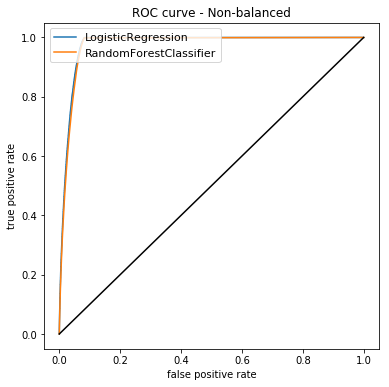

In [22]:
#mpl.rc("savefig", dpi=300)
# with rejected
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
#feed training and testing data into train_test_split
#test size is 40%, making training set 60%
#If int, random_state is the seed used by the random number generator;
#A random seed (or seed state, or just seed) is a number (or vector) 
#used to initialize a pseudorandom number generator and set initial value 
#random_state is 0

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
#now focus on models report and confidence matrix
#run models using data set and non balanced, outputs will be assigned to output report and matrix

In [23]:
models_report #now to get a report of the models

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.235777,0.976480,0.549329,0.106919,0.178999,Non-balanced
1,RandomForestClassifier,0.236444,0.973966,0.495141,0.120257,0.193515,Non-balanced


In [24]:
conf_matrix['RandomForestClassifier'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,1244366,3429
1,24602,3363


In [25]:
conf_matrix['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990


# 2015 w chargeoff only

computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


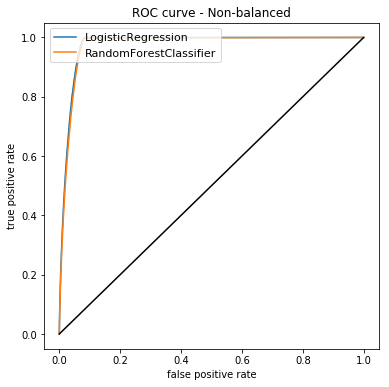

In [85]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
#feed training and testing data into train_test_split
#test size is 40%, making training set 60%
#If int, random_state is the seed used by the random number generator;
#A random seed (or seed state, or just seed) is a number (or vector) 
#used to initialize a pseudorandom number generator and set initial value 
#random_state is 0

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
#now focus on models report and confidence matrix
#run models using data set and non balanced, outputs will be assigned to output report and matrix

In [89]:
models_report #now to get a report of the models

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.235777,0.976480,0.549329,0.106919,0.178999,Non-balanced
1,RandomForestClassifier,0.238424,0.974012,0.498824,0.121294,0.195139,Non-balanced


In [90]:
conf_matrix['RandomForestClassifier'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,1244387,3408
1,24573,3392


In [91]:
conf_matrix['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990


clearly this model is predictive regardless of the rejected variable

# 2016

computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 


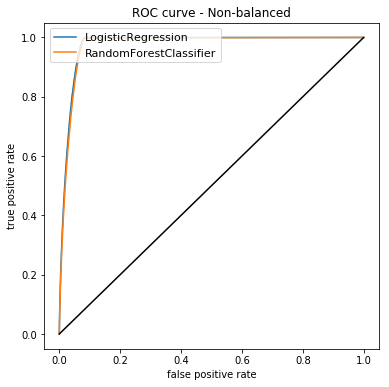

In [85]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
#feed training and testing data into train_test_split
#test size is 40%, making training set 60%
#If int, random_state is the seed used by the random number generator;
#A random seed (or seed state, or just seed) is a number (or vector) 
#used to initialize a pseudorandom number generator and set initial value 
#random_state is 0

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
#now focus on models report and confidence matrix
#run models using data set and non balanced, outputs will be assigned to output report and matrix

In [89]:
models_report #now to get a report of the models

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.235777,0.976480,0.549329,0.106919,0.178999,Non-balanced
1,RandomForestClassifier,0.238424,0.974012,0.498824,0.121294,0.195139,Non-balanced


In [90]:
conf_matrix['RandomForestClassifier'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,1244387,3408
1,24573,3392


In [90]:
conf_matrix['LogisticRegression'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,1244387,3408
1,24573,3392


# 2017

In [ ]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
#feed training and testing data into train_test_split
#test size is 40%, making training set 60%
#If int, random_state is the seed used by the random number generator;
#A random seed (or seed state, or just seed) is a number (or vector) 
#used to initialize a pseudorandom number generator and set initial value 
#random_state is 0

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
#now focus on models report and confidence matrix
#run models using data set and non balanced, outputs will be assigned to output report and matrix

computing LogisticRegression - Non-balanced 


In [39]:
models_report #now to get a report of the models

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.235777,0.976480,0.549329,0.106919,0.178999,Non-balanced
1,RandomForestClassifier,0.236362,0.973934,0.495644,0.120043,0.193275,Non-balanced


In [40]:
conf_matrix['RandomForestClassifier'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,1244379,3416
1,24608,3357


In [41]:
conf_matrix['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990


# 2018

In [ ]:
#mpl.rc("savefig", dpi=300)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)
#feed training and testing data into train_test_split
#test size is 40%, making training set 60%
#If int, random_state is the seed used by the random number generator;
#A random seed (or seed state, or just seed) is a number (or vector) 
#used to initialize a pseudorandom number generator and set initial value 
#random_state is 0

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
#now focus on models report and confidence matrix
#run models using data set and non balanced, outputs will be assigned to output report and matrix

computing LogisticRegression - Non-balanced 


In [39]:
models_report #now to get a report of the models

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.235777,0.976480,0.549329,0.106919,0.178999,Non-balanced
1,RandomForestClassifier,0.236362,0.973934,0.495644,0.120043,0.193275,Non-balanced


In [40]:
conf_matrix['RandomForestClassifier'] #the confidence matrix for random forest

Predicted,0,1
True,,
0,1244379,3416
1,24608,3357


In [41]:
conf_matrix['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990


# Improving Our Model
##Modelling with Balanced Classes

Using SMOTE ( Synthetic Minority Over-sampling Technique), we can aritifically balance our classes and get a better prediction.

We use a K-nearest neighbour approach and make feature vectors resembling the target variable's. The minority class is oversampled. With this, the model performance will improve.

In [26]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced'): #run_models is used below to run them
    #define the funciton run models, with the parameters:
    #X_train: training data set
    #Y_train: set of labels to all the data in x_train
    #The training set is a subset of the data set used to train a model.
    #X_test: test data set
    #y_test:  set of labels to all the data in x_test
    #model_type: specify the type of model we want to use
    #we select non-balanced for now, just to see how the initial model will fare
    
    clfs = { 'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100) } #n_estimators sets the number of trees in forest for model}
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    #Establish which methods we want to use - Logistic Regression and Random Forest - with the clfs line that creates a dictionary
    #of the two
    #cols establishes a list of the specific columns of metrics we want
    
    models_report = pd.DataFrame(columns = cols) #this is used to generate an empty model report
    conf_matrix = dict() #create a dictionary for the confidence matrix that assigns the confidence values to specific keys

    for clf, clf_name in zip(clfs.values(), clfs.keys()): 
        #establish a for loop saying that for each method name and value,

        clf.fit(X_train, y_train)
        #Train the model by fitting it to data, using the training data set as inputs
        
        y_pred = clf.predict(X_test) #the predicted labels that will be returned from 
        #.predict, which predicts target values of X given a model
        y_score = clf.predict_proba(X_test)[:,1] #the Target scores, 
        #can either be probability estimates of the positive class, confidence values, 
        #or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
        #obtained using .predict_proba, which is a
        #method of a (soft) classifier outputting the probability of the instance being in each of the classes.
        
        print('computing {} - {} '.format(clf_name, model_type)) #print output saying that the file is computing
        #specific model, which is why.format is used at end to pull name and model type to plug into statement

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})
        #create a dictionary of series names and keys assigning values for what each item is
        #the keys are the desired items we want in the end for our model analysis, with the values
        #explaining how each key is assigned/calculated 
        
        models_report = models_report.append(tmp, ignore_index = True)
        #append the tmp values to our currently empty model report
        #ignore_index = True means we ignore and do not use the index labels, do this as the report needs to show
        #only the names, not the methods for how each item is analyzed
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        #establish the confidence matrix, crosstab Compute a simple cross-tabulation of two (or more) factors.
        #Cross tabulation is a tool that allows you compare the relationship between two or more factors.
        #Can you tell what factors are we cross tabulating?
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
        #the returns of the ROC curve, all three are arrays 
        #hence use of metrics.roc_curve, uses y test data and target scores to determine three return values
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
        #plotting dimensions and specifics for the result graph
    
    return models_report, conf_matrix
    #after running function, also give us models_report and confidence matrix for methods

# 2015

In [27]:
index_split = int(len(X)/2)#split index in by length of X/2
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
#use SMOTE to fit sample
#Define X parameter to fit to and Y
#new training data set
X_test, y_test = X_scaled[index_split:], y[index_split:]
#define test data
#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

In [28]:
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
#same as before, but change model type to balanced now
#The “balanced” mode uses the values of y to automatically adjust weights 
#inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

computing RandomForestClassifier - Balanced 


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
models_report_bal #balanced report

In [ ]:
conf_matrix_bal['RandomForestClassifier'] #balanced logistic regression

In [41]:
conf_matrix_bal['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990


# 2016

In [47]:
index_split = int(len(X)/2)#split index in by length of X/2
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
#use SMOTE to fit sample
#Define X parameter to fit to and Y
#new training data set
X_test, y_test = X_scaled[index_split:], y[index_split:]
#define test data

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

computing LogisticRegression - Balanced 


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
#same as before, but change model type to balanced now
#The “balanced” mode uses the values of y to automatically adjust weights 
#inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [ ]:
models_report_bal #balanced report

In [ ]:
conf_matrix_bal['RandomForestClassifier'] #balanced logistic regression

In [41]:
conf_matrix_bal['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990


# 2017

In [ ]:
models_report_bal #balanced report

In [47]:
index_split = int(len(X)/2)#split index in by length of X/2
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
#use SMOTE to fit sample
#Define X parameter to fit to and Y
#new training data set
X_test, y_test = X_scaled[index_split:], y[index_split:]
#define test data

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

computing LogisticRegression - Balanced 


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
#same as before, but change model type to balanced now
#The “balanced” mode uses the values of y to automatically adjust weights 
#inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [ ]:
models_report_bal #balanced report

In [ ]:
conf_matrix_bal['RandomForestClassifier'] #balanced logistic regression

In [41]:
conf_matrix_bal['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990


# 2018

In [47]:
index_split = int(len(X)/2)#split index in by length of X/2
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
#use SMOTE to fit sample
#Define X parameter to fit to and Y
#new training data set
X_test, y_test = X_scaled[index_split:], y[index_split:]
#define test data

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')

computing LogisticRegression - Balanced 


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
#same as before, but change model type to balanced now
#The “balanced” mode uses the values of y to automatically adjust weights 
#inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [ ]:
models_report_bal #balanced report

In [ ]:
conf_matrix_bal['RandomForestClassifier'] #balanced logistic regression

In [41]:
conf_matrix_bal['LogisticRegression'] #the confidence matrix for logistic regression

Predicted,0,1
True,,
0,1245342,2453
1,24975,2990
